# Evaluate Outputs

This notebook evaluates outputs of the recommendation model(s).

## Setup

What data set?

In [1]:
data = 'ml-20m'

Let's import some things:

In [2]:
from pathlib import Path
import re
import logging

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import ttest_rel
import statsmodels.api as sm

In [5]:
from lenskit import topn
from lenskit.datasets import MovieLens
from lenskit.util.log import log_to_notebook

In [6]:
_log = logging.getLogger('eval-notebook')
log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


In [7]:
from tqdm.notebook import tqdm
tqdm.pandas()

## Load Data

### Test Data

We're going to start by loading the test data:

In [8]:
ml = MovieLens(f'data/{data}')
split_dir = Path(f'data/{data}-split')

In [9]:
movies = ml.movies
movies.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Scan for and load test data:

In [10]:
test_re = re.compile(r'^part(?P<part>\d+)-test')
test_frames = {}
for file in split_dir.glob('*-test.parquet'):
    match = test_re.match(file.name)
    part = int(match.group('part'))
    test_frames[part] = pd.read_parquet(file)

In [11]:
test_ratings = pd.concat(test_frames, names=['part'])
test_ratings = test_ratings.reset_index('part').reset_index(drop=True)
test_ratings.head()

,part,user,item,rating,timestamp
0,1,2,2291,2.0,974820748
1,1,2,3753,4.0,974820691
2,1,2,3173,4.0,974820869
3,1,2,2858,3.0,974820659
4,1,2,1214,5.0,974821014


### Outputs

Now let's load prediction & recommendation data.

A regular expression will parse file names:

In [12]:
adn_re = re.compile(r'^(?P<data>.*?)-(?P<algo>[A-Z].*)')
fn_re = re.compile(r'part(?P<part>\d+)-(?:recs|preds)')

Load predictions:

In [13]:
pred_frames = {}
for file in Path('preds').glob(f'{data}-*/*-preds.parquet'):
    _log.info('loading %s', file)
    dmatch = adn_re.match(file.parent.name)
    algo = dmatch.group('algo')
    fmatch = fn_re.match(file.name)
    part = int(fmatch.group('part'))
    df = pd.read_parquet(file)
    pred_frames[(algo, part)] = df

[   INFO] eval-notebook loading preds/ml-20m-BIAS/part3-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-BIAS/part2-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-BIAS/part5-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-BIAS/part1-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-BIAS/part4-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-E-MF/part1-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-E-MF/part4-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-E-MF/part2-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-E-MF/part3-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-E-MF/part5-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-TorchMF/part5-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-TorchMF/part2-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-TorchMF/part3-preds.parquet
[   INFO] eval-notebook loading preds/ml-20m-TorchMF/part1-preds.parquet
[   INFO

In [14]:
preds = pd.concat(pred_frames, names=['algo', 'part'])
preds = preds.reset_index(['algo', 'part']).reset_index(drop=True)
preds.head()

,algo,part,user,item,rating,timestamp,prediction
0,BIAS,3,3,2391,5.0,944918215,4.320703
1,BIAS,3,3,1079,4.0,944917797,4.449816
2,BIAS,3,3,1762,4.0,945176072,3.349052
3,BIAS,3,3,2012,3.0,945176021,3.849842
4,BIAS,3,3,1278,5.0,944917980,4.597338


And now the recommendations:

In [15]:
rec_frames = {}
for file in Path('recs').glob(f'{data}-*/*-recs.parquet'):
    _log.info('loading %s', file)
    dmatch = adn_re.match(file.parent.name)
    algo = dmatch.group('algo')
    fmatch = fn_re.match(file.name)
    part = int(fmatch.group('part'))
    df = pd.read_parquet(file)
    rec_frames[(algo, part)] = df

[   INFO] eval-notebook loading recs/ml-20m-POP/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-POP/part3-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-POP/part2-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-POP/part5-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-POP/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-BIAS/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-BIAS/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-BIAS/part2-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-BIAS/part5-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-BIAS/part3-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-E-MF/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-E-MF/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-E-MF/part3-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-E-MF/part5-recs.parquet
[   INFO] eval-notebook loading recs/ml-20m-E-MF/part

In [16]:
recs = pd.concat(rec_frames, names=['algo', 'part'])
recs = recs.reset_index(['algo', 'part']).reset_index(drop=True)
recs.head()

,algo,part,item,score,user,rank
0,POP,1,296,66465.0,2,1
1,POP,1,356,65402.0,2,2
2,POP,1,318,62527.0,2,3
3,POP,1,593,62493.0,2,4
4,POP,1,2571,50852.0,2,5


## Prediction Accuracy

Now, let's compute the per-user RMSE of each algorithm.

In [17]:
preds['sqerr'] = np.square(preds['rating'] - preds['prediction'])
user_rmse = preds.groupby(['algo', 'user'])['sqerr'].mean()
user_rmse = user_rmse.to_frame('RMSE').reset_index()
user_rmse.head()

,algo,user,RMSE
0,BIAS,1,0.179533
1,BIAS,2,1.822353
2,BIAS,3,0.394376
3,BIAS,4,0.299858
4,BIAS,5,0.677434


Numeric summaries of RMSE:

In [18]:
user_rmse.groupby('algo')['RMSE'].describe()

,count,mean,std,min,25%,50%,75%,max
algo,,,,,,,,
BIAS,138493.0,0.817927,0.741992,0.002089,0.320637,0.591444,1.061369,10.585650
E-MF,138493.0,0.702842,0.664401,0.000343,0.265660,0.499812,0.906287,10.513610
TorchMF,138493.0,0.727099,0.658605,0.001931,0.287087,0.531985,0.943278,8.944472


Plot it:

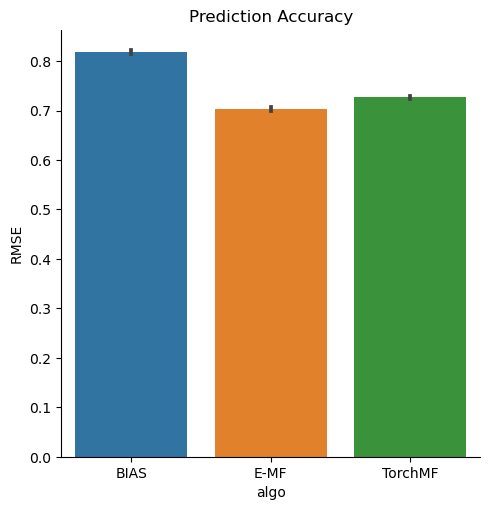

In [19]:
sns.catplot(user_rmse, x='algo', y='RMSE', kind='bar')
plt.title('Prediction Accuracy')
plt.show()

## Recommendation Utility

Now let's evaluate the top-*N* recommendations.

In [20]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.hit, k=20)
rla.add_metric(topn.recip_rank, k=20)
rla.add_metric(topn.ndcg, k=20)
user_scores = rla.compute(recs, test_ratings)
user_scores.reset_index(inplace=True)
user_scores

[   INFO] lenskit.topn analyzing 19943000 recommendations (692465 truth rows)
[   INFO] lenskit.topn using rec key columns ['algo', 'part', 'user']
[   INFO] lenskit.topn using truth key columns ['part', 'user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 997150 lists in 12.16s


,algo,part,user,nrecs,hit,recip_rank,ndcg
0,POP,1,2,20,1.0,0.076923,0.058387
1,POP,1,7,20,0.0,0.000000,0.000000
2,POP,1,10,20,0.0,0.000000,0.000000
3,POP,1,16,20,1.0,0.058824,0.045499
4,POP,1,18,20,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
997145,SampLMF,1,138476,20,1.0,0.166667,0.148915
997146,SampLMF,1,138480,20,1.0,0.142857,0.183287
997147,SampLMF,1,138481,20,0.0,0.000000,0.000000
997148,SampLMF,1,138483,20,1.0,0.500000,0.465655


In [21]:
us_tall = user_scores.melt(id_vars=['algo', 'user'], value_vars=['recip_rank', 'hit', 'ndcg'], var_name='Metric')
us_tall

,algo,user,Metric,value
0,POP,2,recip_rank,0.076923
1,POP,7,recip_rank,0.000000
2,POP,10,recip_rank,0.000000
3,POP,16,recip_rank,0.058824
4,POP,18,recip_rank,0.000000
...,...,...,...,...
2991445,SampLMF,138476,ndcg,0.148915
2991446,SampLMF,138480,ndcg,0.183287
2991447,SampLMF,138481,ndcg,0.000000
2991448,SampLMF,138483,ndcg,0.465655


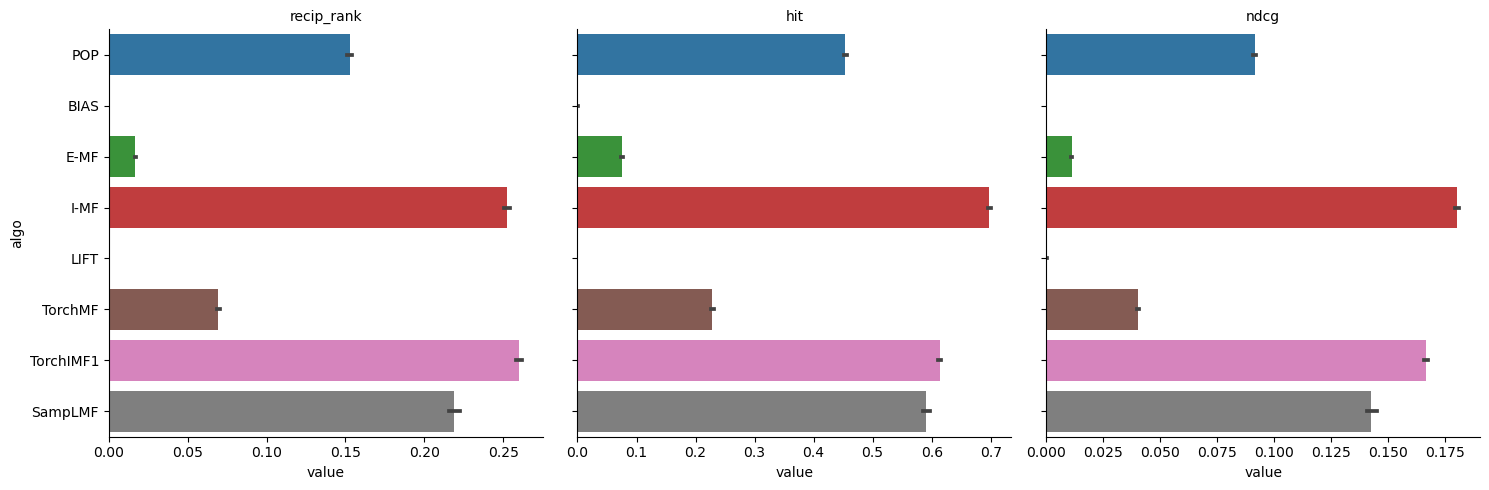

In [24]:
g = sns.catplot(us_tall, y='algo', x='value', col='Metric', kind='bar', sharex=False)
g.set_titles('{col_name}')
g.set_xlabels(None)
plt.show()